### In this project, we aim to perform sentiment analysis on IMDb movie reviews using the powerful BERT (Bidirectional Encoder Representations from Transformers) model. Sentiment analysis involves determining the sentiment expressed in a piece of text, and in this case, we're focused on classifying movie reviews as either positive or negative.

In [16]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### We will be working with the IMDb review dataset, a widely used benchmark for sentiment analysis. This dataset contains a collection of movie reviews along with their corresponding sentiments.

### We start by loading in the dataset

In [3]:
imdb_data=pd.read_csv('./dataset/IMDB_Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


### Given the extended training time of the model, we decide to reduce the dataset size while maintaining an even distribution of sentiment labels.

In [20]:
samples_per_label = 5000

imdb_data_subset = imdb_data.groupby('sentiment', group_keys=False).apply(lambda x: x.head(samples_per_label))

### Before proceeding with model training, let's verify that the dataset has the same amount of labels.

In [21]:
imdb_data_subset['sentiment'].value_counts()

sentiment
negative    5000
positive    5000
Name: count, dtype: int64

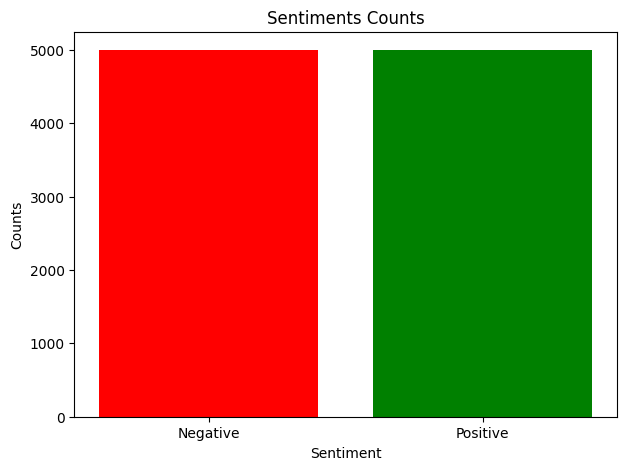

In [27]:
sentiment_counts = imdb_data_subset['sentiment'].value_counts()

# Skapa stapeldiagram med pyplot
plt.bar(['Negative', 'Positive'], sentiment_counts.values, color=['red', 'green'])
plt.title('Sentiments Counts')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.show()

### To assess the performance of our sentiment analysis model, we split the dataset into training and test sets. For this specific configuration, we aim to have 4000 samples for each sentiment label in the training set and 1000 samples for each label in the test set.

In [24]:
train_samples_per_label = 4000
test_samples_per_label = 1000
train_df, test_df = train_test_split(imdb_data_subset, stratify=imdb_data_subset['sentiment'], 
                                       train_size=train_samples_per_label*2, test_size=test_samples_per_label*2, random_state=42)

### Before feeding the text data into the model, it's essential to preprocess it. The following function, `text_cleaning`, utilizes BeautifulSoup and regular expressions to clean the text from HTML tags and special characters.

In [8]:
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

### Now that we have defined the `text_cleaning` function, let's apply it to the review text in both the training and test datasets.

In [9]:
# Train dataset
train_df['Cleaned_sentence'] = train_df['review'].apply(text_cleaning).tolist()
# Test dataset
test_df['Cleaned_sentence'] = test_df['review'].apply(text_cleaning)

C:\Users\Nicla\AppData\Local\Temp\ipykernel_8440\3524044076.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
C:\Users\Nicla\AppData\Local\Temp\ipykernel_8440\3757904458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Cleaned_sentence'] = train_df['review'].apply(text_cleaning).tolist()
C:\Users\Nicla\AppData\Local\Temp\ipykernel_8440\3524044076.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
C:\Users\Nicla\AppData\Local\T

### To gain insights into the distribution of review lengths in the training dataset, a bar chart is created. Each bar represents the number of characters in a respective review.

[Text(0.5, 1.0, 'No. of characters in each review'),
 Text(0.5, 0, 'Number of review'),
 Text(0, 0.5, 'Number of Characters in each review')]

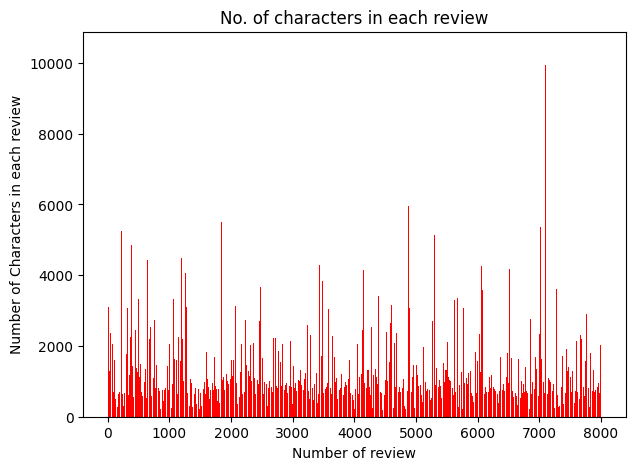

In [28]:
sentences = [len(sent) for sent in train_df['review']]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,8001), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each review', xlabel='Number of review', ylabel='Number of Characters in each review')

### Now that the text data has been cleaned, we can prepare the reviews and their corresponding sentiment labels for model training.

In [11]:
reviews = train_df['Cleaned_sentence']
target = train_df['sentiment']

test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

### To facilitate binary classification, the sentiment labels are converted into boolean values. The target labels for both the training and test datasets are generated based on the condition of being 'positive' or not.

In [12]:
train_y = np.array(target) == 'positive'
test_y = np.array(test_targets) == 'positive'
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((6000,), (1000,), 0.49533333333333335, 0.501)

### To assess the model's performance on unseen data, we split the test dataset into a validation set (`x_val`, `y_val`) and a final test set (`x_test`, `y_test`). The split is done while ensuring a balanced distribution of sentiment labels.

In [13]:
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
                                                    test_y,
                                                    test_size=0.5, 
                                                    stratify = test_targets)

### For tokenizing the text data using the BERT model, we initialize the tokenizer from the 'bert-base-uncased' pre-trained model with lowercase tokenization.

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

### To prepare the text data for input to the BERT model, we tokenize and encode the sentences using the BERT tokenizer. The maximum length of the sequences is set to 300.

In [15]:
max_len= 300
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(reviews.tolist(),
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

### Now, let's initialize the BERT model for sequence classification. We use the 'bert-base-uncased' pre-trained model with two output labels for binary classification.

In [15]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### To prepare the BERT model for training, we compile it with the specified optimizer, loss function, and metrics.

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

### Let's train the BERT model on the provided training data. The training history is stored in the `history` variable.

In [17]:
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    train_y,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
    batch_size=32,
    epochs=3
)

Epoch 1/3

188/188 [==============================] - 2003s 11s/step - loss: 0.4227 - accuracy: 0.7797 - val_loss: 0.1207 - val_accuracy: 0.9580
Epoch 2/3
188/188 [==============================] - 1986s 11s/step - loss: 0.1778 - accuracy: 0.9363 - val_loss: 0.0549 - val_accuracy: 0.9860
Epoch 3/3
188/188 [==============================] - 1988s 11s/step - loss: 0.0922 - accuracy: 0.9732 - val_loss: 0.0261 - val_accuracy: 0.9960


### Now, let's evaluate the trained BERT model on the test data to assess its performance.

In [18]:
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

16/16 [==============================] - 47s 3s/step - loss: 0.0454 - accuracy: 0.9860
Test loss: 0.045367445796728134, Test accuracy: 0.9860000014305115


### To preserve the trained BERT model and the associated tokenizer for future use, let's save them to the specified path.

In [19]:
path = './model/'
# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')
 
# Save model
model.save_pretrained(path +'/Model')

### To use the saved BERT tokenizer and model for inference, let's load them from the specified path.

In [20]:
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')
 
# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')

Some layers from the model checkpoint at ./model//Model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./model//Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


### Let's use the loaded BERT model to make predictions on the test data and compare them with the actual labels.

In [21]:
pred = bert_model.predict(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])
 
# pred is of type TFSequenceClassifierOutput
logits = pred.logits
 
# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)
 
# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()
 
label = {
    1: 'positive',
    0: 'Negative'
}
 
# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]
 
print('Predicted Label :', pred_labels[:10])
print('Actual Label    :', Actual[:10])

16/16 [==============================] - 49s 3s/step
Predicted Label : ['Negative', 'Negative', 'positive', 'Negative', 'Negative', 'Negative', 'Negative', 'positive', 'positive', 'Negative']
Actual Label    : ['Negative', 'Negative', 'positive', 'Negative', 'Negative', 'Negative', 'Negative', 'positive', 'positive', 'Negative']


### To provide a comprehensive evaluation of the model's performance, let's generate a classification report based on the predicted and actual labels.

In [22]:
print("Classification Report: \n", classification_report(Actual, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.98      1.00      0.99       249
    positive       1.00      0.98      0.99       251

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



### Here is a Python function, `Get_sentiment`, that takes a review or a list of reviews as input and returns the predicted sentiment labels using the loaded BERT tokenizer and model.


In [23]:
def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
    # Convert Review to a list if it's not already a list
    if not isinstance(Review, list):
        Review = [Review]
    label = {
        1: 'positive',
        0: 'Negative'
    }
    Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
                                                                             padding=True,
                                                                             truncation=True,
                                                                             max_length=300,
                                                                             return_tensors='tf').values()

    prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

    # Use argmax along the appropriate axis to get the predicted labels
    pred_labels = tf.argmax(prediction.logits, axis=1)

    # Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
    pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
    return pred_labels

### Let's use the `Get_sentiment` function to predict the sentiment for the provided review.

In [24]:
Review ="""Too much cgi, too much lenght, too boring characters, (ecept my precious thing )
so many better fantasties out there.
Zzz too overated. The first one was better. Oh, and the rings are boring too. And the walking trees. Ok, they are ok for a bit. Cant really thionk of anything positive to say. Think ill watch willow insted."""

Get_sentiment(Review)

1/1 [==============================] - 1s 1s/step


['Negative']

### The BERT sentiment analysis model has completed training, and now it's time to incorporate it into the `app.py` project. In this project, users can input an IMDb movie link to fetch the latest 25 reviews and receive a sentiment label (positive/negative) for each review. Additionally, users can input a single review for sentiment analysis.